In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.utils as utils
import torchvision.utils as vutils
from torch.optim import SGD
import torch.utils.data as Data
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_data = torchvision.datasets.MNIST(
    root = "./data/MNIST",
    train = True,
    transform=torchvision.transforms.ToTensor(),
    download=False
)
train_loader = Data.DataLoader(
    dataset = train_data,
    batch_size=128,
    shuffle=True,
    num_workers=0
)
test_data = torchvision.datasets.MNIST(
    root = "./data/MNIST",
    train = False,
    download=False
)
test_data_x =test_data.data.type(torch.FloatTensor) / 255.0
test_data_x = torch.unsqueeze(test_data_x, dim = 1)
test_data_y = test_data.targets
print("test_data_x.shape:", test_data_x.shape)
print("test_data_y.shape:", test_data_y.shape)

test_data_x.shape: torch.Size([10000, 1, 28, 28])
test_data_y.shape: torch.Size([10000])


In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.AvgPool2d(
                kernel_size=2,
                stride=2
            ),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc = nn.Sequential(
            nn.Linear(
                in_features=32*7*7,
                out_features=128
            ),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU()
        )
        self.out = nn.Linear(64,10)
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        output = self.out(x)
        return output

In [4]:
MyConvnet = ConvNet()

In [5]:
print(MyConvnet)

ConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (out): Linear(in_features=64, out_features=10, bias=True)
)


#  hiddenlayer可视化网络

In [6]:
import hiddenlayer as hl
#可视化卷积神经网络
hl_graph = hl.build_graph(MyConvnet, torch.zeros([1,1,28,28]))

In [7]:
hl_graph.theme = hl.graph.THEMES["blue"].copy()
#将可视化的网络保存为图片
hl_graph.save("data/MyConvnet_hl.png", format="png")

In [8]:
import torch
print(torch.__version__)  #注意是双下划线

1.5.1+cu101


#  PyTorchViz可视化网络

In [9]:
from torchviz import make_dot

In [10]:
x = torch.randn(1, 1, 28, 28).requires_grad_(True)#指定输入
y = MyConvnet(x)
MyConvnetvis = make_dot(y, params=dict(list(MyConvnet.named_parameters())+[("x", x)]))  
MyConvnetvis.format = "png" #指定文件类型
MyConvnetvis.directory = "data/MyConvnetvis"  #指定路径
MyConvnetvis.view()   #保存

'data/MyConvnetvis\\Digraph.gv.png'

#   tensorboardX训练过程可视化

###  tensorboard --logdir="log/"  port=8080
###  localhost:8080

In [24]:
from tensorboardX import SummaryWriter
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SumWriter = SummaryWriter(log_dir="data/log/test")
MyConvnet = ConvNet().to(device)
#定义优化器
optimizer = torch.optim.Adam(MyConvnet.parameters(), lr=0.0003)
loss_func = nn.CrossEntropyLoss()
train_loss = 0
print_step = 100
for epoch in range(5):
    for step, (b_x, b_y) in enumerate(train_loader):
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        output = MyConvnet(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss

        #计算迭代次数
        niter = epoch * len(train_loader) + step + 1
        #计算每经过print_step次迭代的输出
        if niter % print_step == 0:
            #为日志添加训练集损失函数
            SumWriter.add_scalar(tag="train loss", scalar_value=train_loss.item()/niter, global_step=niter)
            #计算测试集上的精度
            test_data_x = test_data_x.to(device)
            output = MyConvnet(test_data_x)
            _, pre_lab = torch.max(output,1)
            # test_data_y = test_data_y.to(device)
            pre_lab = pre_lab.data.cpu().numpy()
            acc = accuracy_score(test_data_y, pre_lab)
            SumWriter.add_scalar('test acc', acc.item(), niter)
            print("acc",acc.item(),"print_step:", niter)
            #为日志中添加训练数据的可视化图像，使用当前btach的图像
            #将一个batch的数据进行预处理
            b_x_im = vutils.make_grid(b_x, nrow = 12)
            SumWriter.add_image('train image sample', b_x_im, niter)
            #使用直方图可视化网络中参数的分布情况
            for name, param in MyConvnet.named_parameters():
                SumWriter.add_histogram(name, param.data.cpu().numpy(), niter)

acc 0.7616 print_step: 100
acc 0.8641 print_step: 200
acc 0.8928 print_step: 300
acc 0.9151 print_step: 400
acc 0.9183 print_step: 500
acc 0.9261 print_step: 600
acc 0.9353 print_step: 700
acc 0.9399 print_step: 800
acc 0.9439 print_step: 900
acc 0.9524 print_step: 1000
acc 0.9552 print_step: 1100
acc 0.9599 print_step: 1200
acc 0.9541 print_step: 1300
acc 0.9634 print_step: 1400
acc 0.9649 print_step: 1500
acc 0.9694 print_step: 1600
acc 0.9694 print_step: 1700
acc 0.97 print_step: 1800
acc 0.97 print_step: 1900
acc 0.9754 print_step: 2000
acc 0.9749 print_step: 2100
acc 0.977 print_step: 2200
acc 0.9764 print_step: 2300


ERROR:visdom:Connection is already closed.
ERROR:visdom:[WinError 10061] 由于目标计算机积极拒绝，无法连接。
ERROR:visdom:[WinError 10061] 由于目标计算机积极拒绝，无法连接。


# HiddenLayer可视化训练过程

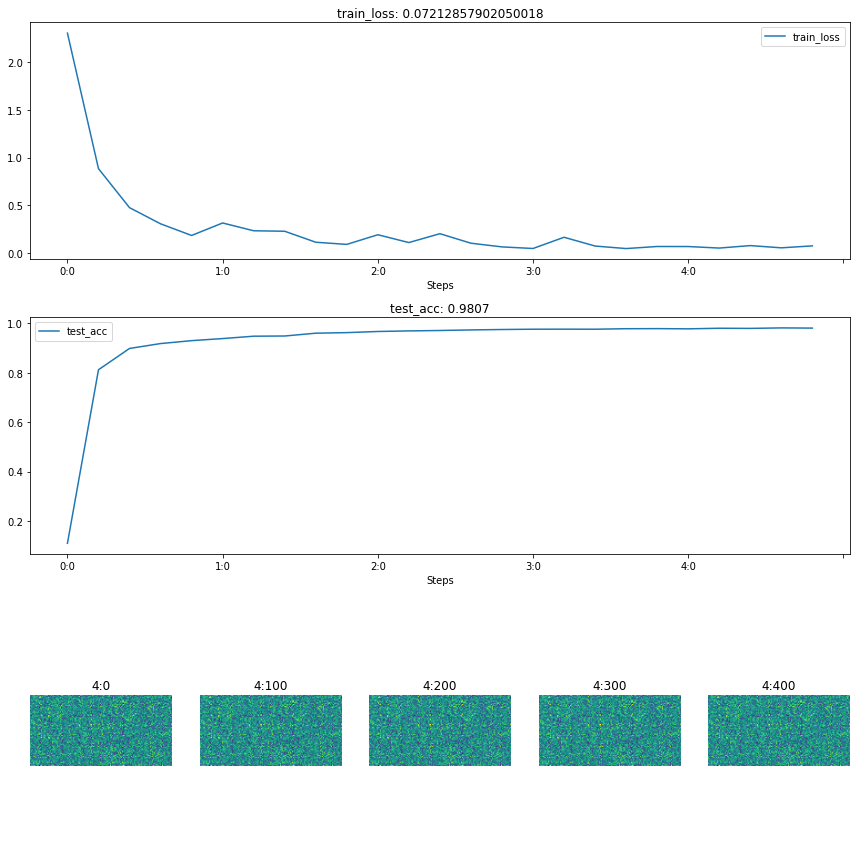

In [12]:
import hiddenlayer as hl
import time
#初始化MyConvnet
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MyConvnet = ConvNet()
MyConvnet = ConvNet().to(device)
#定义优化器
optimizer = torch.optim.Adam(MyConvnet.parameters(), lr = 0.0003)
loss_func = nn.CrossEntropyLoss()
#记录训练指标
history1 = hl.History()
#使用Canvas进行可视化
canvas1 = hl.Canvas()
print_step = 100

for epoch in range(5):
    for step, (b_x, b_y) in enumerate(train_loader):
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        output = MyConvnet(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #计算迭代次数
        #计算每经过print_step次迭代的输出
        if step % print_step == 0:
            #计算测试集上的精度
            test_data_x = test_data_x.to(device)
            output = MyConvnet(test_data_x)
            _, pre_lab = torch.max(output,1)
            pre_lab = pre_lab.data.cpu().numpy()
            acc = accuracy_score(test_data_y, pre_lab)
            history1.log((epoch, step), 
                        train_loss=loss,
                        test_acc = acc,
                       hidden_weight = MyConvnet.fc[2].weight)
#             print("acc",acc.item(),"print_step:", niter)
            #可视化训练过程
            with canvas1:
                canvas1.draw_plot(history1["train_loss"])
                canvas1.draw_plot(history1["test_acc"])
                canvas1.draw_image(history1["hidden_weight"])

#   使用visdom进行数据可视化

In [15]:
from visdom import Visdom
from sklearn.datasets import load_iris
iris_x,iris_y = load_iris(return_X_y=True)
print(iris_x.shape)
print(iris_y.shape)

(150, 4)
(150,)


###  首先要执行 python -m visdom.server 激活visdom服务
###  然后进入相应的页面查看可视化信息   http://localhost:8097/

In [17]:
#2D散点图
vis = Visdom()
vis.scatter(iris_x[:,0:2], Y = iris_y+1, win="windows1", env="main")
#3D散点图
vis.scatter(iris_x[:,0:3],Y = iris_y+1, win="3D散点图", env="main", opts=dict(markersize = 4,
                                                                          xlabel="特征1",
                                                                          ylabel="特征2"))

'3D散点图'

In [18]:
#添加折线图
x = torch.linspace(-6,6,100).view((-1,1))
sigmoid = torch.nn.Sigmoid()
sigmoidy = sigmoid(x)
tanh = torch.nn.Tanh()
tanhy = tanh(x)
relu = torch.nn.ReLU()
reluy = relu(x)
ploty = torch.cat((sigmoidy, tanhy, reluy),dim=1)
plotx = torch.cat((x,x,x),dim=1)
vis.line(Y = ploty, X=plotx, win="line plot", env="main",
        opts=dict(dash=np.array(["solid","dash","dashdot"]),
                 legend = ["Sigmoid","Tanh","ReLU"]))


'line plot'

In [19]:
#茎叶图
x = torch.linspace(-6,6,100).view((-1,1))
y1 = torch.sin(x)
y2 = torch.cos(x)
plotx = torch.cat((y1,y2),dim=1)
ploty = torch.cat((x,x),dim=1)
vis.stem(X = plotx,Y=ploty,win="stem plot", env="main",
        opts = dict(legend=["sin","cos"],
                   title = "茎叶图"))

'stem plot'

In [20]:
#热力图
iris_corr = torch.from_numpy(np.corrcoef(iris_x,rowvar=False))
vis.heatmap(iris_corr, win="heatmap", env="main",
           opts = dict(rownames = ["x1","x2","x3","x4"],
                      clonumnnames = ["x1","x2","x3","x4"],
                      title = "热力图"))

'heatmap'

In [21]:
#创建新的可视化图像环境
for step,(b_x, b_y) in enumerate(train_loader):
    if step>0:
        break
print(b_x.shape)
print(b_y.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [22]:
#可视化其中的一张图片
vis.image(b_x[0,:,:,:],win="one image",env="MyimagePlot",opts=dict(title="一张图像"))
#它形成一个大小为（B/nrow,nrow）
vis.images(b_x,win="my batch image",env="MyimagePlot",nrow=16,opts=dict(title="一个批次的图像"))

'my batch image'

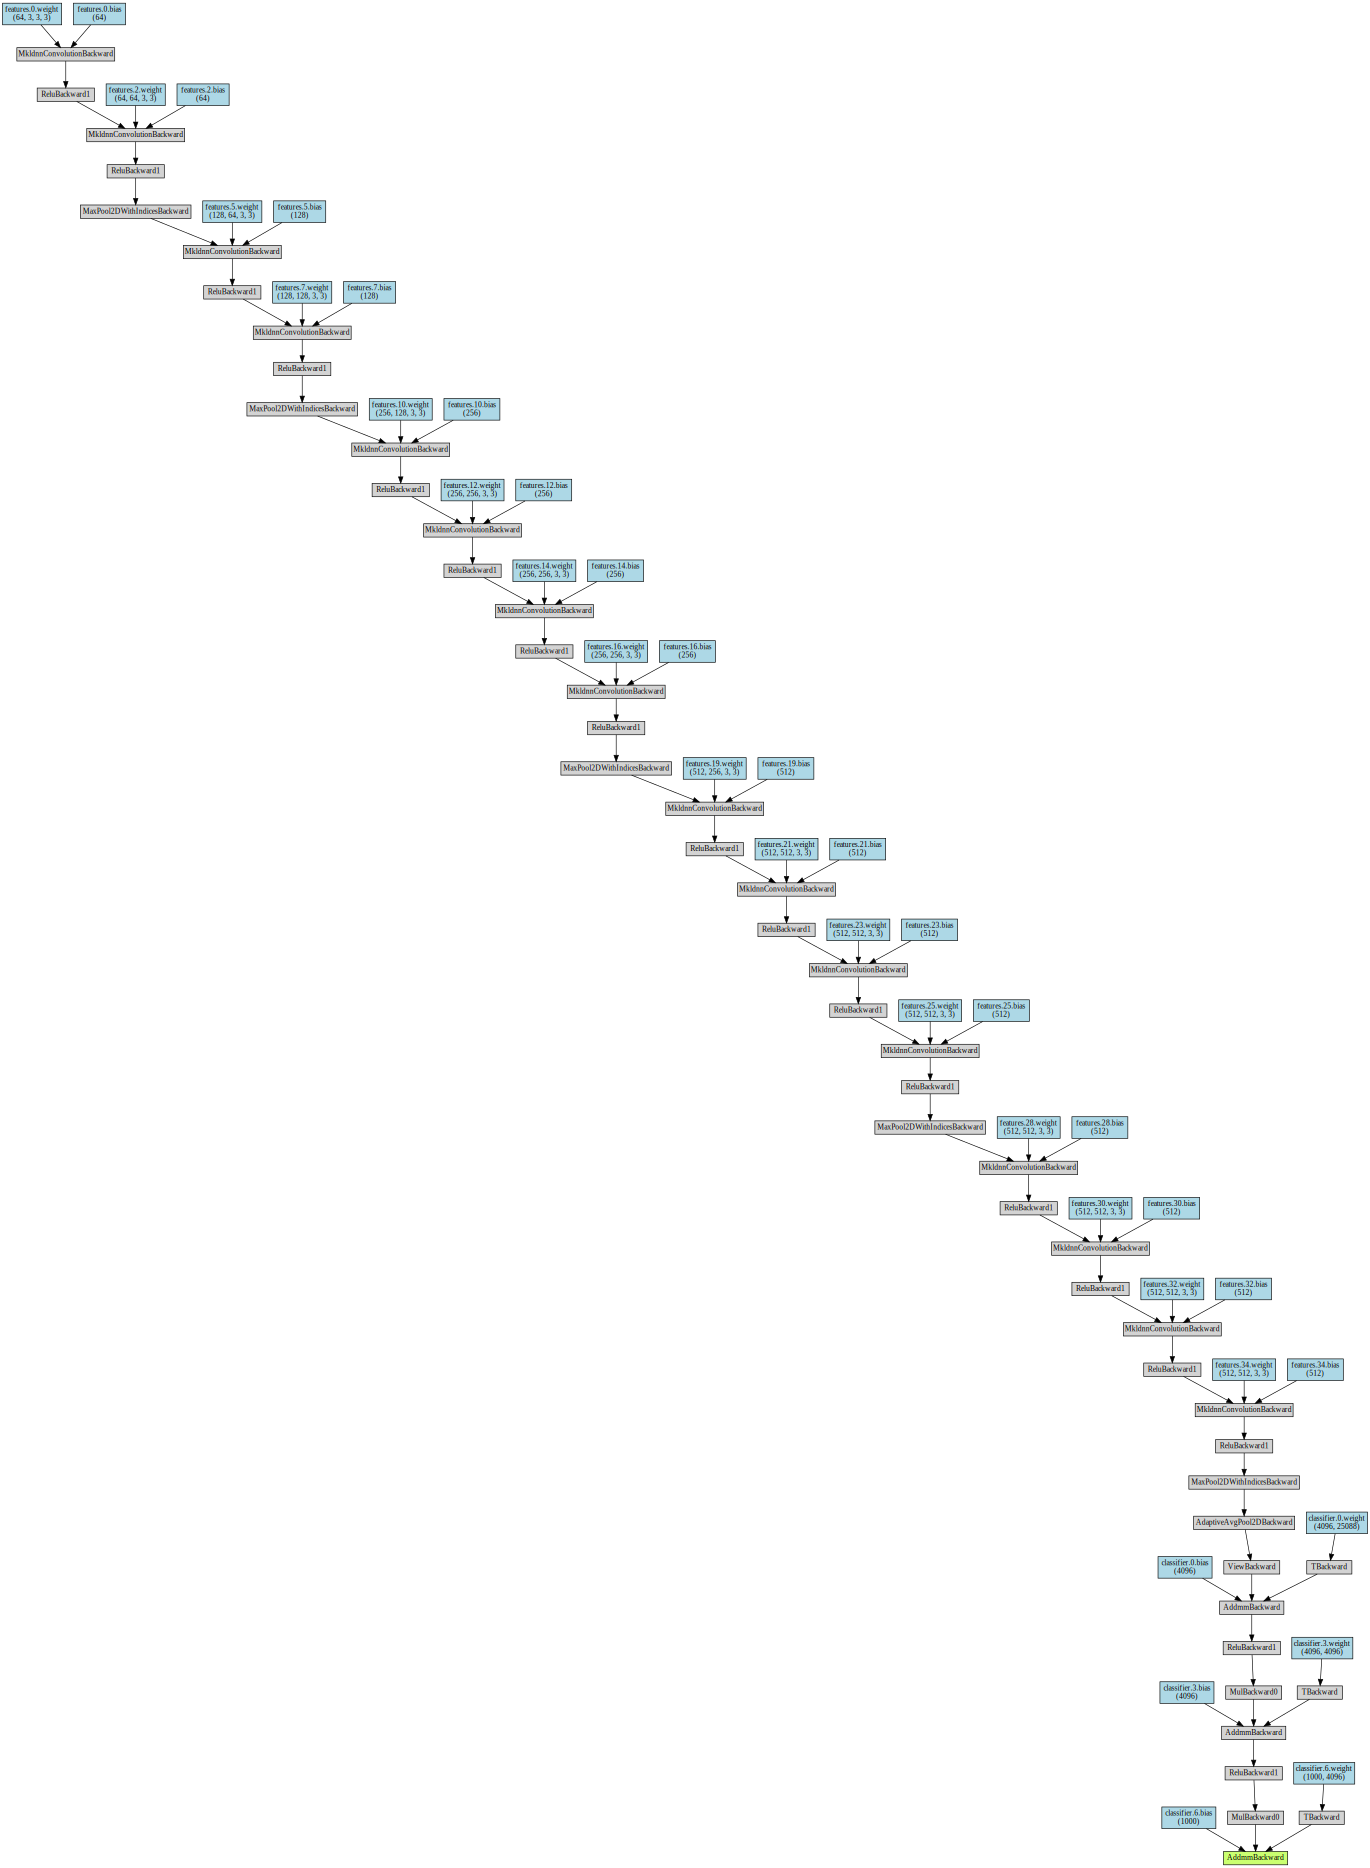

In [23]:
import torch
from torch import nn
from torchviz import make_dot, make_dot_from_trace
from torchvision import models
model = models.vgg19()
x = torch.randn(10,3,224,224)
make_dot(model(x), params=dict(model.named_parameters()))